<center>
<img src="./imgs/ncf.png" width="800">
</center>

# Download the data
[Movie Lens Small](https://www.kaggle.com/datasets/shubhammehta21/movie-lens-small-latest-dataset)

In [49]:
!pip install tensorflow
!pip install pandas
!pip install numpy


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [50]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout, Multiply, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt

In [51]:
ratings = pd.read_csv('1m-data/ratings.csv')

ratings.head()

,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [52]:
# Map ratings to user and item ids to a continuous range
user_ids = ratings['userId'].astype('category').cat.codes.values
item_ids = ratings['movieId'].astype('category').cat.codes.values
ratings['user_id'] = user_ids
ratings['item_id'] = item_ids

# Prepare training data
train, test = train_test_split(ratings, test_size=0.2, random_state=42)

# Extract user Ids, item Ids and ratings
train_users_ids = train['user_id'].values
train_items_ids = train['item_id'].values
# Consider only ratings greater than or equal to 3 as positive
train_ratings = (train['rating'] >= 3).astype(int).values

# Extract user Ids, item Ids and ratings
test_users_ids = test['user_id'].values
test_items_ids = test['item_id'].values
# Consider only ratings greater than or equal to 3 as positive
test_ratings = (test['rating'] >= 3).astype(int).values

In [53]:
# Hyperparameters
num_users = ratings['user_id'].nunique()
num_items = ratings['item_id'].nunique()
embedding_size = 50
hidden_units = [128, 64, 32]
dropout_rate = 0.25

# Input
user_input = Input(shape=(1,), name='user_input')
item_input = Input(shape=(1,), name='item_input')

# Embedding GMF
user_embedding_gmf = Embedding(num_users, embedding_size, name='user_embedding_gmf')(user_input)
item_embedding_gmf = Embedding(num_items, embedding_size, name='item_embedding_gmf')(item_input)

# Flatten GMF
user_embedding_gmf = Flatten()(user_embedding_gmf)
item_embedding_gmf = Flatten()(item_embedding_gmf)

# Element-wise product for GMF
gmf_output = Multiply()([user_embedding_gmf, item_embedding_gmf])

# Embedding MLP
user_embedding_mlp = Embedding(num_users, embedding_size, name='user_embedding_mlp')(user_input)
item_embedding_mlp = Embedding(num_items, embedding_size, name='item_embedding_mlp')(item_input)

# Flatten MLP
user_embedding_mlp = Flatten()(user_embedding_mlp)
item_embedding_mlp = Flatten()(item_embedding_mlp)

# Concat embeddings for MLP
mlp_concat = Concatenate()([user_embedding_mlp, item_embedding_mlp])

# MLP
for hidden_unit in hidden_units:
    mlp_concat = Dense(hidden_unit, activation='relu', kernel_regularizer=regularizers.l2(0.01))(mlp_concat)
    mlp_concat  = BatchNormalization()(mlp_concat)
    mlp_concat = Dropout(dropout_rate)(mlp_concat)

# Concat GMF and MLP
concat = Concatenate()([gmf_output, mlp_concat])

# Output
output = Dense(1, activation='sigmoid')(concat)

optimizer = Adam(learning_rate=0.0001)

# Model
model = Model(inputs=[user_input, item_input], outputs=output)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding_mlp  │ (None, 1, 50)     │    302,000 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_embedding_mlp  │ (None, 1, 50)     │    185,300 │ item_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_30          │ (None, 50)        │          0 │ user_embedding_m… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_31          │ (None, 50)        │          0 │ item_embedding_m… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_14      │ (None, 100)       │          0 │ flatten_30[0][0], │
│ (Concatenate)       │                   │            │ flatten_31[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 128)       │     12,928 │ concatenate_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_28[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 64)        │      8,256 │ dropout_21[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_29[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 64)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding_gmf  │ (None, 1, 50)     │    302,000 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_embedding_gmf  │ (None, 1, 50)     │    185,300 │ item_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 32)        │      2,080 │ dropout_22[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_28          │ (None, 50)        │          0 │ user_embedding_g… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_29          │ (None, 50)        │          0 │ item_embedding_g

 Total params: 998,843 (3.81 MB)

 Trainable params: 998,395 (3.81 MB)

 Non-trainable params: 448 (1.75 KB)

In [54]:
# Train the model
history = model.fit([train_users_ids,train_items_ids],train_ratings,
batch_size=100,epochs=10,validation_split=0.2)

Epoch 1/10
6402/6402 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step - accuracy: 0.7002 - loss: 1.7990 - val_accuracy: 0.8534 - val_loss: 0.4579
Epoch 2/10
6402/6402 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.8526 - loss: 0.4184 - val_accuracy: 0.8587 - val_loss: 0.3534
Epoch 3/10
6402/6402 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.8598 - loss: 0.3457 - val_accuracy: 0.8614 - val_loss: 0.3413
Epoch 4/10
6402/6402 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.8633 - loss: 0.3326 - val_accuracy: 0.8615 - val_loss: 0.3418
Epoch 5/10
6402/6402 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.8663 - loss: 0.3258 - val_accuracy: 0.8619 - val_loss: 0.3384
Epoch 6/10
6402/6402 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.8688 - loss: 0.3176 - val_accuracy: 0.8624 - val_loss: 0.3366
Epoch 7/10
6402/6402 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - accuracy: 0.8724 - loss: 0.3101 - val_accuracy: 0.8624 - val_loss: 0.3352
Epoch 8/10
6402/6402 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.8771 - loss: 0

In [55]:
# Evaluate
loss, accuracy = model.evaluate([test_users_ids, test_items_ids], test_ratings)
print('Test loss: ', loss)
print('Test accuracy: ', accuracy)

# Predict
user_id = np.array([1])
item_id = np.array([1])
prediction = model.predict([user_id, item_id])
print(
    f"Prediction for user {user_id[0]} and item {item_id[0]}: {prediction[0][0]}")

6252/6252 ━━━━━━━━━━━━━━━━━━━━ 6s 904us/step - accuracy: 0.8631 - loss: 0.3330
Test loss:  0.33319592475891113
Test accuracy:  0.8632287383079529
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
Prediction for user 1 and item 1: 0.8639758825302124


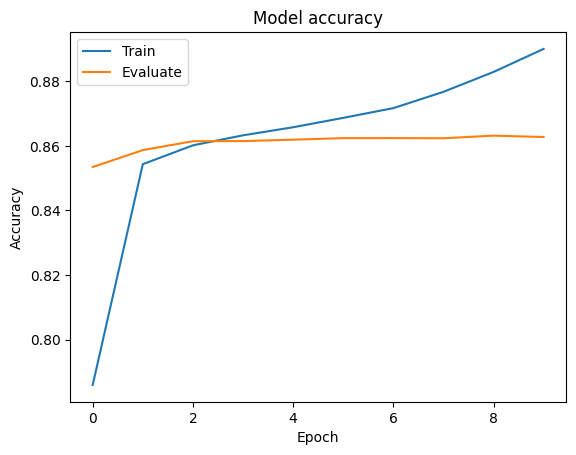

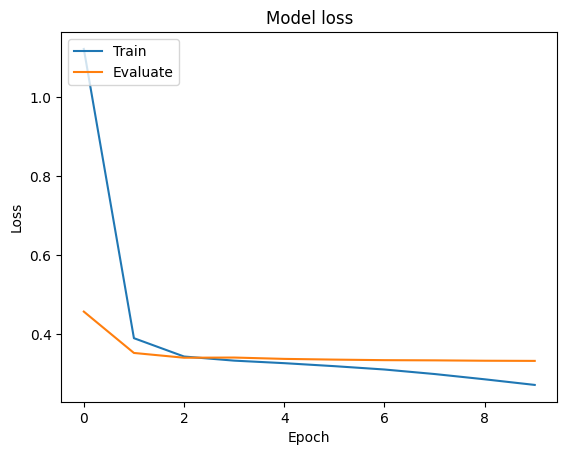

In [56]:
# Plot training and test accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Evaluate'], loc='upper left')
plt.show()

# Plot training and test loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Evaluate'], loc='upper left')
plt.show()